In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('md2.csv', index_col='ID')
df.head()

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


,Age,Age_Group,Education,High_Education,Marital_Status,Relationship,Income,Income_Group,Kidhome,Teenhome,...,NumStorePurchases,Total_NumPurchases,NumWebVisitsMonth,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,Complain
ID,,,,,,,,,,,,,,,,,,,,,
1173,75,70-80,Master,1,Together,1,77632.0,75000 - 79000,0,0,...,6,25,2,0,0,0,1,1,1,0
6036,63,60-70,Master,1,Together,1,89120.0,87000 - 91000,0,0,...,7,18,1,0,0,0,0,1,0,0
10140,39,30-40,PhD,1,Together,1,70123.0,67000 - 71000,0,0,...,4,21,3,0,1,0,1,0,0,0
5386,69,60-70,Graduation,0,Together,1,94384.0,91000 - 95000,0,0,...,5,43,2,1,0,0,1,1,1,0
5831,55,50-60,Graduation,0,Married,1,77870.0,75000 - 79000,0,1,...,5,22,8,1,0,0,1,0,1,0


In [3]:
df_c4 = df[['Age', 'Education', 'Marital_Status','Income', 'Kidhome', 'Teenhome', 'AcceptedCmp4']]
df_c4.head()

,Age,Education,Marital_Status,Income,Kidhome,Teenhome,AcceptedCmp4
ID,,,,,,,
1173,75,Master,Together,77632.0,0,0,1
6036,63,Master,Together,89120.0,0,0,0
10140,39,PhD,Together,70123.0,0,0,1
5386,69,Graduation,Together,94384.0,0,0,1
5831,55,Graduation,Married,77870.0,0,1,1


In [4]:
X = pd.get_dummies(df_c4.drop('AcceptedCmp4', axis=1))
y = df_c4['AcceptedCmp4']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [7]:
feature_names = X.columns
feature_names

Index(['Age', 'Income', 'Kidhome', 'Teenhome', 'Education_2n Cycle',
       'Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Marital_Status_YOLO'],
      dtype='object')

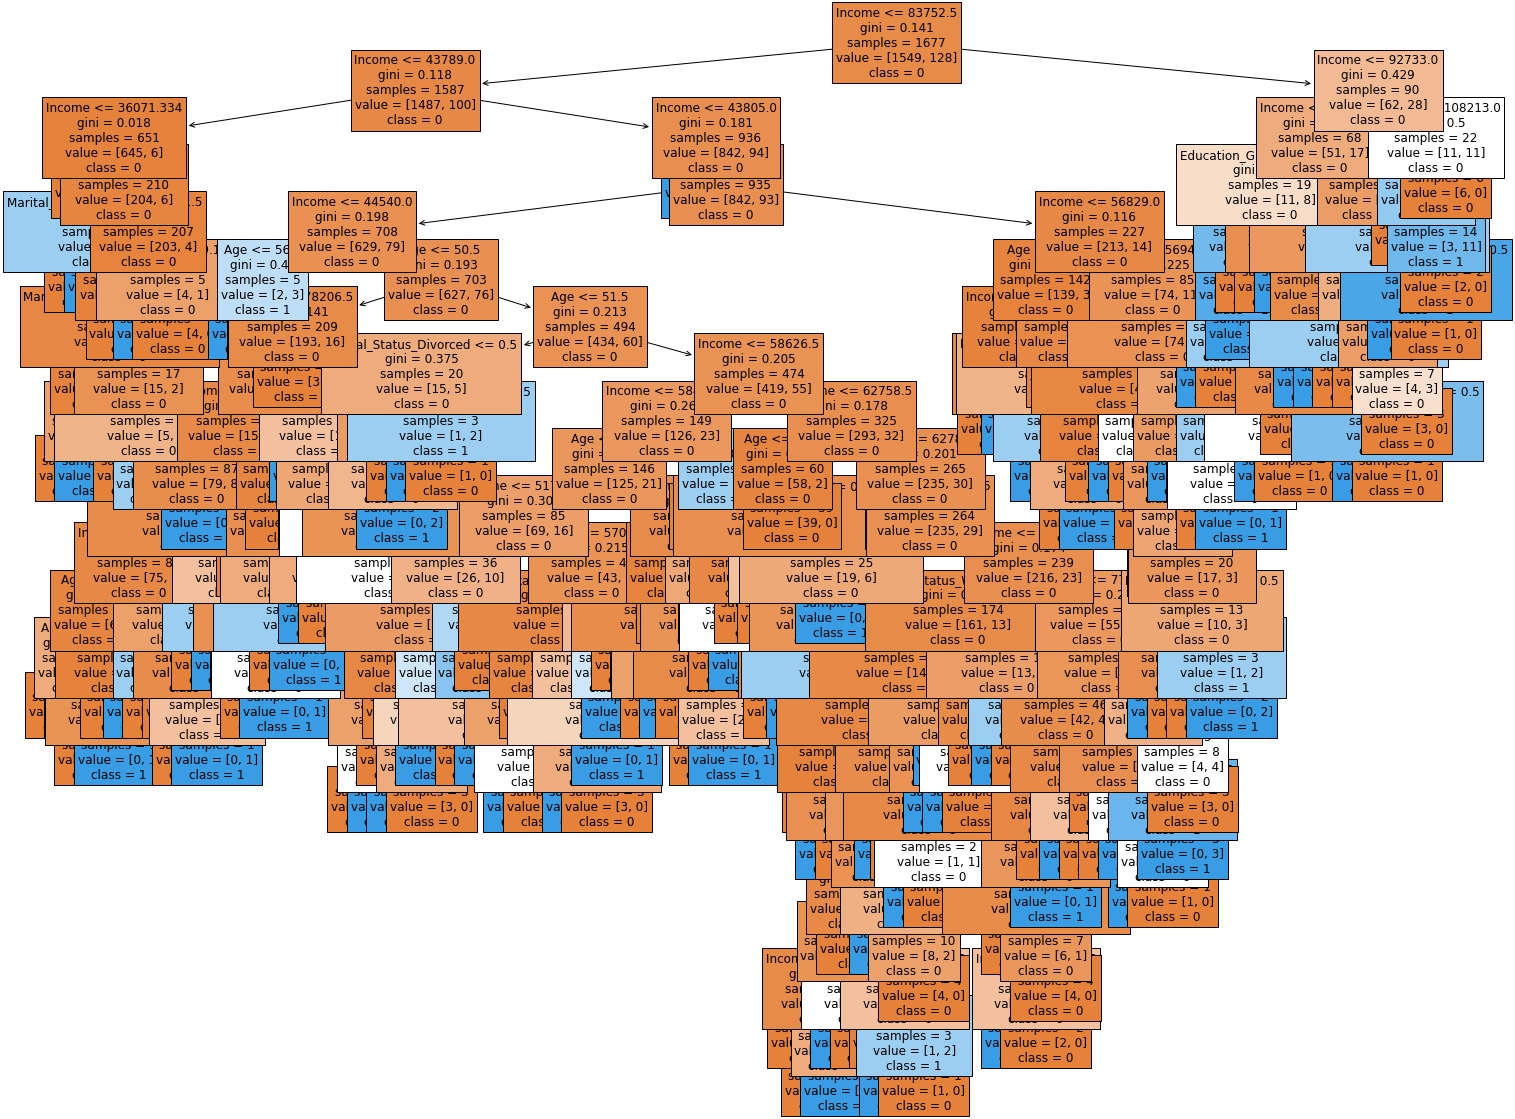

In [8]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=feature_names, 
                   class_names=['0','1'], 
                   filled=True, 
                   fontsize=12)

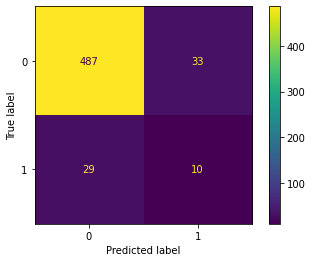

In [9]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [10]:
print("Model Accuracy: %.3f%%" % (model.score(X_test, y_test)*100.0))

Model Accuracy: 88.909%


In [11]:
path =  model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

models = []

for ccp_alpha in ccp_alphas:
    model = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    models.append(model)

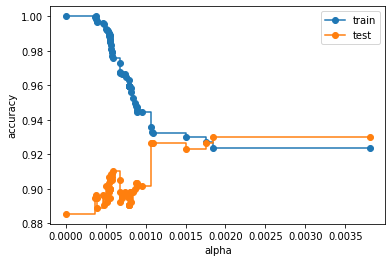

In [12]:
train_scores = [model.score(X_train, y_train) for model in models]
test_scores = [model.score(X_test, y_test) for model in models]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.plot (ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot (ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

<AxesSubplot:xlabel='alpah'>

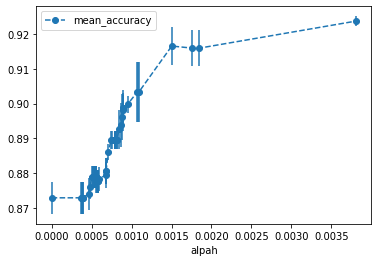

In [13]:
alpah_loop_values = []

for ccp_alpha in ccp_alphas:
    model = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores =  cross_val_score(model, X_train, y_train, cv=5)
    alpah_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    
alpah_results = pd.DataFrame(alpah_loop_values, columns=['alpah', 'mean_accuracy', 'std'])

alpah_results.plot(x='alpah',
                  y='mean_accuracy',
                  yerr='std',
                  marker='o',
                  linestyle="--")

In [14]:
ideal_alpah = alpah_results[(alpah_results['alpah'] > 0.0015) & (alpah_results['alpah'] < 0.0019)]['alpah']
ideal_alpah

53    0.001503
54    0.001758
55    0.001849
Name: alpah, dtype: float64

In [15]:
ideal_alpah = 0.0017

In [16]:
model_pruned = tree.DecisionTreeClassifier(ccp_alpha=ideal_alpah)
model_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0017)

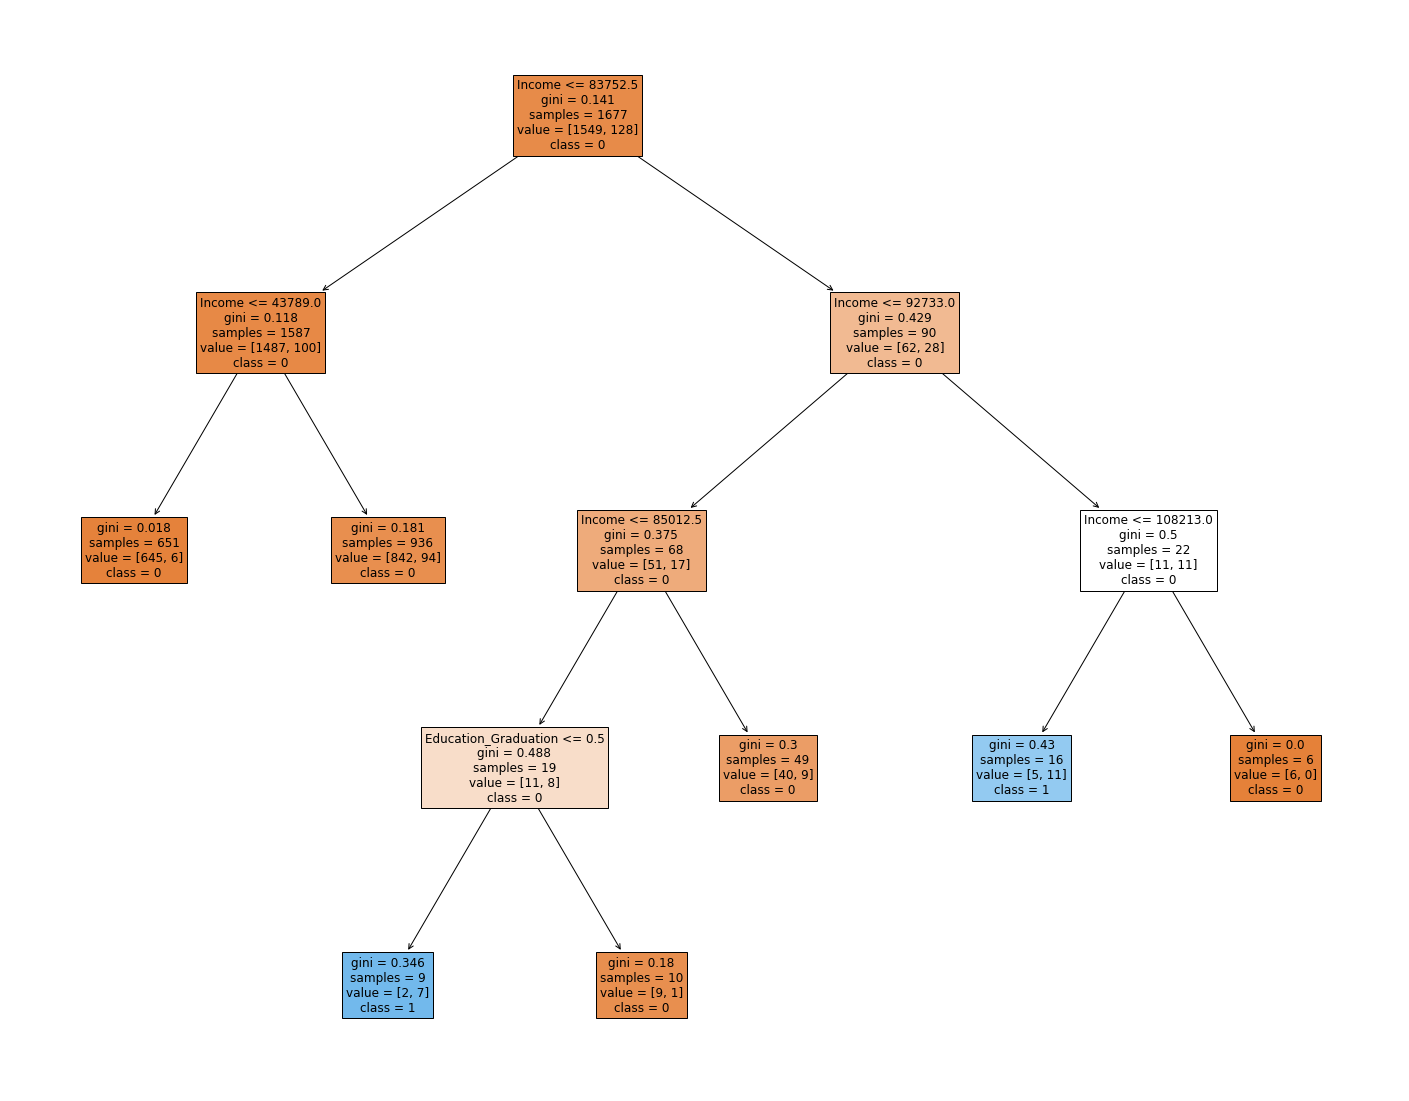

In [17]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model_pruned, 
                   feature_names=feature_names, 
                   class_names=['0','1'], 
                   filled=True, 
                   fontsize=12)

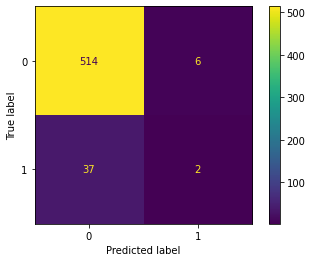

In [18]:
ConfusionMatrixDisplay.from_estimator(model_pruned, X_test, y_test)

In [19]:
print("Model Accuracy: %.3f%%" % (model_pruned.score(X_test, y_test)*100.0))

Model Accuracy: 92.308%


In [20]:
model_pruned.feature_importances_

array([0.        , 0.84978075, 0.        , 0.        , 0.        ,
       0.        , 0.15021925, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

<AxesSubplot:>

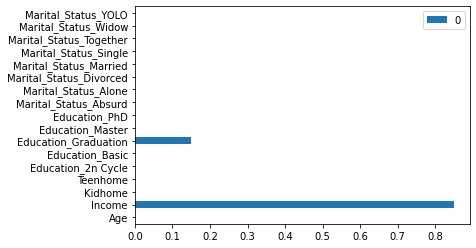

In [21]:
feature_importances = pd.DataFrame(model_pruned.feature_importances_, index=feature_names)
feature_importances.plot(kind='barh')